# Example usage of the BBTD class (Constrained ADMM)

In [1]:
import pybbtd.bbtd as bbtd
import numpy as np
from pybbtd.visualization import draw_metrics, draw_bbtd

In [2]:
np.random.seed(0)
# Define tensor size and BBTD parameters
J, M, K = 20, 25, 4  # spatial dims (M, J) and covariance dim K
R = 3  # number of BBTD terms
L1 = 3  # rank of the first block (A, B)
L2 = 2  # rank of the second block (C, D)

# The 4D tensor has shape (J, M, K, K) due to covariance structure
X = bbtd.BBTD([J, M, K, K], R, L1, L2)

Sufficient condition for uniqueness satisfied


In [3]:
from pybbtd.uniqueness import check_uniqueness_BBTD

# Check uniqueness of the BBTD model
is_unique = check_uniqueness_BBTD(J, M, K, K, R, L1, L2)
print(f"Uniqueness guaranteed: {is_unique}")

Uniqueness guaranteed: True


In [4]:
# Create ground truth tensor respecting the constraints
# A, B non-negative; D = C*
A0 = np.random.rand(J, L1 * R)
B0 = np.random.rand(M, L1 * R)
C0 = np.random.randn(K, L2 * R) + 1j * np.random.randn(K, L2 * R)
D0 = C0.conj()

phi, psi = X.get_constraint_matrices()

T0 = bbtd.factors_to_tensor(A0, B0, C0, D0, phi, psi)
T_observed = T0 + 1e-6 * np.random.randn(*X.dims)

Progress: 20.0 %
Progress: 40.0 %
Exiting early at iteration 233 due to relative tolerance.


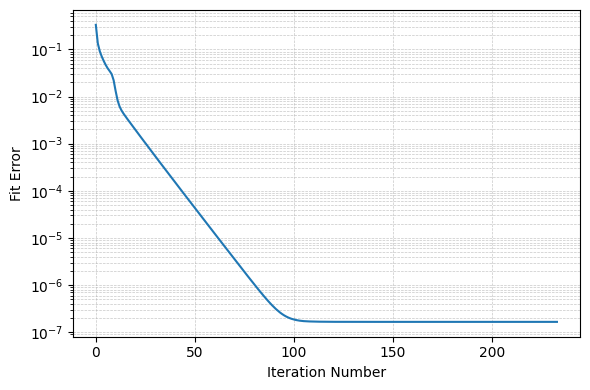

In [5]:
# Fit the model using ADMM with kmeans initialization
X.fit(
    T_observed,
    algorithm="ADMM",
    init="kmeans",
    max_iter=500,
    gamma=1.0,
    rho=1.0,
    inner_admm=50,
    tol_admm=1e-8,
    rel_tol=1e-9,
    abs_tol=1e-15,
)

# Retrieve the estimated factors
A_est, B_est, C_est, D_est = X.factors

# Check convergence curve
draw_metrics.plot_error(X.fit_error)

In [6]:
# Verify constraints
L1 = X.L1
R = X.rank

# Check non-negativity of each spatial map S_r = A_r @ B_r^T
for r in range(R):
    S_r = A_est[:, r * L1 : (r + 1) * L1] @ B_est[:, r * L1 : (r + 1) * L1].T
    print(f"S_{r} = A_{r} @ B_{r}^T non-negative: {np.all(S_r >= -1e-10)}")

print(f"D ≈ C*: {np.allclose(D_est, C_est.conj())}")

S_0 = A_0 @ B_0^T non-negative: True
S_1 = A_1 @ B_1^T non-negative: True
S_2 = A_2 @ B_2^T non-negative: True
D ≈ C*: True


In [7]:
X_est = bbtd.factors_to_tensor(A_est, B_est, C_est, D_est, phi, psi)
print(np.linalg.norm(T0 - X_est) / np.linalg.norm(T0))  # relative error

3.0108540301376864e-08


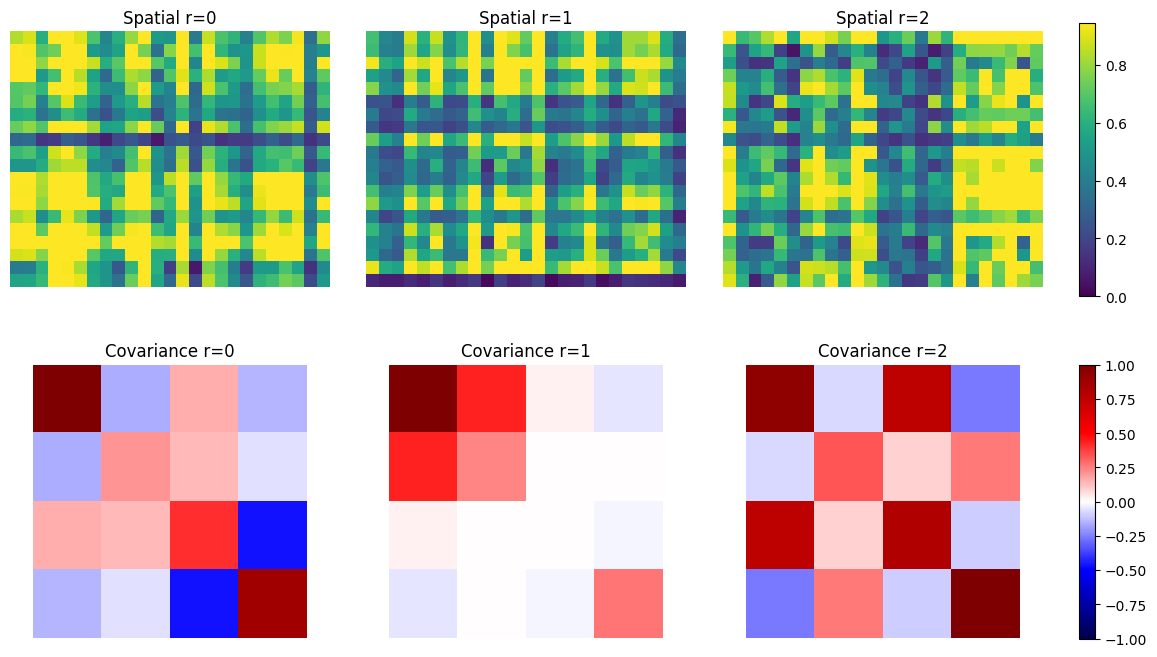

In [8]:
draw_bbtd.plot_BBTD_cov_terms(A_est, B_est, C_est, R, L1, L2)